In [1]:
from lib import Data
from lib import dataset_prep_functions as data_prep
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Reading Data of Stock

In [2]:
# read data by stock ticker and date defining the range of data you want to access
data = Data.Data('AAL', '2013-07-01')  

read processed data


In [3]:
data.data_frame.head(3)

,price,volume,s&p500,ebit,total current assets,total current liabilities,net cash from total operating activities,gdp [USA],unemployment [USA]
2013-07-01,16.05,12511796.0,1614.96,1177.49,10710.36,15060.93,466.47,16848.75,11335.00
2013-07-02,15.69,10748794.0,1614.08,1175.68,10733.97,15052.73,469.72,16851.30,11333.19
2013-07-03,16.00,7039678.0,1615.41,1173.86,10757.58,15044.53,472.97,16853.84,11331.39


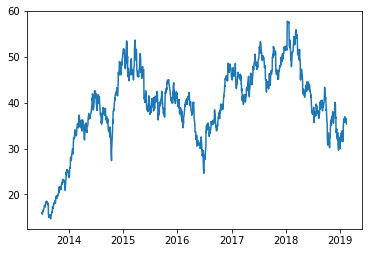

In [4]:
plt.plot(data.data_frame['price'])

## 2. Training and Model Configurations

In [ ]:
# configs
SUBSEQ_LEN = 100  # length of sequences fed into rnn
HORIZON = 50  # number of days to predict into future
VALID_RATIO = 0.1  # percent of validation data
BATCH_SIZE = 15
LSTM_SIZES = [128, 128]  # size of lstm states per layer
EPOCHS = 150
LEARNING_RATE = 1e-5

## 3. Prepairing Data

In [ ]:
# get non overlapping data sequences for later prediction test 
test_data_sequences = data_prep.get_subsequences(data.data_frame.values, SUBSEQ_LEN, False)
fake_labels = np.zeros(test_data_sequences.shape, dtype=np.float32)
test_data_sequences.shape, fake_labels.shape

((20, 100, 9), (20, 100, 9))

In [ ]:
# split data into features x and labels y
x, y = data_prep.create_labels(data.data_frame)
x.shape, y.shape

((2054, 9), (2054, 9))

In [ ]:
# get overlapping subsequences of length SUBSEQ_LEN for features and labels
x_seq, y_seq = data_prep.get_subsequences(x, SUBSEQ_LEN), data_prep.get_subsequences(y,SUBSEQ_LEN)
x_seq.shape, y_seq.shape

((1954, 100, 9), (1954, 100, 9))

In [ ]:
# split data into training and validation data based on chosen validation_ratio 
c = np.concatenate((x_seq,y_seq), axis=2)
train, valid = data_prep.split(c, VALID_RATIO)

x_train, x_valid = train[:,:,:-x_seq.shape[-1]], valid[:,:,:-x_seq.shape[-1]]
y_train, y_valid = train[:,:,-x_seq.shape[-1]:], valid[:,:,-x_seq.shape[-1]:]

(x_train.shape, y_train.shape), (x_valid.shape, y_valid.shape)

(((1759, 100, 9), (1759, 100, 9)), ((195, 100, 9), (195, 100, 9)))

In [ ]:
# normalize training and validation sequences (each sequence individually)
x_train, y_train, _ = data_prep.normalize(x_train, y_train)
x_valid, y_valid, _ = data_prep.normalize(x_valid, y_valid)

(x_train.shape, y_train.shape), (x_valid.shape, y_valid.shape)

(((1759, 100, 9), (1759, 100, 9)), ((195, 100, 9), (195, 100, 9)))

## 4. Computation Graph Definition

In [ ]:
tf.reset_default_graph()
# lstm input and output sizes
input_size = x.shape[-1]
output_size = y.shape[-1]

In [ ]:
# batch placeholder
with tf.variable_scope("input", reuse=tf.AUTO_REUSE) as scope:    
    batchX = tf.placeholder(tf.float32, [BATCH_SIZE, SUBSEQ_LEN, input_size], name='batchX')
    batchY = tf.placeholder(tf.float32, [BATCH_SIZE, SUBSEQ_LEN, output_size], name='batchY')

In [ ]:
with tf.variable_scope("LSTM", reuse=tf.AUTO_REUSE) as scope:
    
    # state placeholder 
    c_in = [tf.placeholder(tf.float32, [BATCH_SIZE, s], name='c_{}'.format(c)) for c,s in enumerate(LSTM_SIZES)]
    h_in = [tf.placeholder(tf.float32, [BATCH_SIZE, s], name='h_{}'.format(c)) for c,s in enumerate(LSTM_SIZES)]
    
    # boolean flag to handle training differently from validation and testing
    training_flag = tf.placeholder(tf.bool)
    
    # create LSTMCells
    lstm_layers = [tf.nn.rnn_cell.LSTMCell(size, activation='tanh', forget_bias=1.0) for size in LSTM_SIZES]
    
    # add dropout wrapper keep_prob=0.95 for training, else no dropout keep_prob=1.0
    keep_prob = tf.cond(training_flag, lambda: tf.constant(0.95), lambda: tf.constant(1.0))
    lstm_layers = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob, state_keep_prob=keep_prob, output_keep_prob=keep_prob) for cell in lstm_layers]
    
    # create a RNN cell composed sequentially of the created lstm cells
    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_layers)
    
    # create rnn state input from placeholder
    state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_in, h_in))
    
    # dynamic rnn, calculate output and final state over all lstm layers
    outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                       inputs=batchX,
                                       initial_state=state,
                                       dtype=tf.float32)
    
    rnn_output = tf.transpose(outputs, [1,0,2]) 

In [ ]:
with tf.variable_scope("ReadOut", reuse=tf.AUTO_REUSE) as scope:

    # Initialize all weights and biases.
    initializer = tf.random_normal_initializer(stddev=0.125)

    # define lstm readout weights and biases + dense layer weights and biases
    W_readout = tf.get_variable("W_readout", [LSTM_SIZES[-1], output_size], initializer=initializer)
    b_readout = tf.get_variable("b_readout", [output_size], initializer=initializer)

    # logits calculation
    logits = tf.map_fn(lambda x: tf.matmul(x, W_readout) + b_readout, rnn_output)
    logits = tf.transpose(logits, [1,0,2])

## 5. Definition of Metrics and Training Config

In [ ]:
# define loss as mean squared error
with tf.variable_scope("metrics", reuse=tf.AUTO_REUSE) as scope:    
    loss = tf.losses.mean_squared_error(predictions=logits, labels=batchY)

# define optimizer 
with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE) as scope:
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    training_step = optimizer.minimize(loss)

In [ ]:
# tensorboard summary definition
with tf.variable_scope("summary", reuse=tf.AUTO_REUSE) as scope:    
    tf.summary.scalar('loss', loss)
    merged_summaries = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())
    validation_writer = tf.summary.FileWriter("./summaries/validation", tf.get_default_graph())

## 6. Training, Validation, Prediction

In [ ]:
with tf.Session() as sess:
    
    ##########################################-----TRAINING-PREP-----##########################################

    sess.run(tf.global_variables_initializer())
    
    step = 0
    
    # helper for state initialization
    c_init = tuple(np.zeros([BATCH_SIZE, size]) for size in LSTM_SIZES)
    h_init = tuple(np.zeros([BATCH_SIZE, size]) for size in LSTM_SIZES)
    
    # get list of all placeholders
    placeholders = [op.name + ':0' for op in tf.get_default_graph().get_operations() if op.type == "Placeholder"]

    # prep validation data, splitting into batches but define size 1 instead of batchsize
    valid_batchesX = data_prep.get_subsequences(x_valid, 1, False) 
    valid_batchesY = data_prep.get_subsequences(y_valid, 1, False)
    
    # prep test data, splitting into batches but define size 1 instead of batchsize
    test_batchesX = data_prep.get_subsequences(test_data_sequences, 1, False) 
    test_batchesY = data_prep.get_subsequences(fake_labels, 1, False)
    
    
    ##########################################-----TRAINING-----##########################################
    
    for epoch in range(EPOCHS):
        
        # initialize rnn state new each epoch        
        current_state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_init, h_init))
        
        # shuffle training data before every epoch
        training_data = np.concatenate((x_train, y_train), axis=2)
        np.random.shuffle(training_data)
        
        # split data into batches
        train_batchesX = data_prep.get_subsequences(training_data[:,:,:-x_train.shape[-1]], BATCH_SIZE, False)
        train_batchesY = data_prep.get_subsequences(training_data[:,:,-x_train.shape[-1]:], BATCH_SIZE, False)
        
        
        ##########################################-----TRAINING-STEPS-----##########################################
        
        # go through the training data until it's empty
        for new_batchX, new_batchY in zip(train_batchesX, train_batchesY):
            
            # feed value = batchX, batchY, cell state of every layer, hidden state of every layer, and training flag
            feed_values = [new_batchX, new_batchY] + \
                            [layer[0] for layer in current_state] + \
                            [layer[1] for layer in current_state] + \
                            [True]

            # create feed dictionary from placeholder and feed_values
            feed_dict = {key: val for key, val in zip(placeholders, feed_values)}
            
            # make a training step, get new rnn state and loss
            current_state, summaries, _ = \
                            sess.run([final_state, merged_summaries, training_step], 
                                    feed_dict=feed_dict)

            # write loss to tensorboard
            train_writer.add_summary(summaries, global_step = step)

            step += 1
            
            
        ##########################################-----VALIDATION-----##########################################

        # start validation from zero initial state
        current_state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_init, h_init))
        
        # go through validation data after training one epoch
        for new_batchX, new_batchY in zip(valid_batchesX, valid_batchesY):
            
            # repeating the current sequence, such that it has the correct shape for the placeholder
            new_batchX = np.tile(new_batchX, (BATCH_SIZE,1,1))
            new_batchY = np.tile(new_batchY, (BATCH_SIZE,1,1))
            
            # feed value = batchX, batchY, cell state of every layer, hidden state of every layer, and training flag
            feed_values = [new_batchX, new_batchY] + \
                            [layer[0] for layer in current_state] + \
                            [layer[1] for layer in current_state] + \
                            [False]

            # create feed dictionary from placeholder and feed_values
            feed_dict = {key: val for key, val in zip(placeholders, feed_values)}
            
            # get new rrn state and loss without doing a weight update ie. training step
            current_state, summaries = \
                            sess.run([final_state, merged_summaries], 
                                    feed_dict=feed_dict)

            # write loss to tensorboard
            validation_writer.add_summary(summaries, global_step = step)

            step += 1
            
    ##########################################-----PREDICTION-----##########################################

    # after finishing all epochs start testing via propagation of predictions
    predictions = []

    for new_batchX, new_batchY in zip(test_batchesX, test_batchesY):
        # start predictions from zero state 
        current_state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_init, h_init))
        
        # normalize the current test sequence, saving the origin for later inversion of the normalization
        norm_batchX, norm_batchY, origin = data_prep.normalize(new_batchX, new_batchY)
        
        # repeating the current sequence, such that it has the correct shape for the placeholder
        norm_batchX = np.tile(norm_batchX, (BATCH_SIZE,1,1))
        norm_batchY = np.tile(norm_batchY, (BATCH_SIZE,1,1))
        
        # make predictions according to chosen prediction horizon
        for _ in range(HORIZON):
            
            # feed value = batchX, batchY, cell state of every layer, hidden state of every layer, and training flag
            feed_values = [norm_batchX, norm_batchY] + \
                            [layer[0] for layer in current_state] + \
                            [layer[1] for layer in current_state] + \
                            [False]
            
            # create feed dictionary from placeholder and feed_values
            feed_dict = {key: val for key, val in zip(placeholders, feed_values)}

            # get prediction for current sequence
            output, current_state = sess.run([logits, final_state], feed_dict=feed_dict)
            
            # get shifted sequence by appending the predicting value and dropping the first value
            # again repeating the sequence to make it match the placeholder
            norm_batchX = np.tile(np.append(norm_batchX[0, 1:], [output[0,-1]], axis=0), (BATCH_SIZE,1,1))
        
        # append the predictions, inverting the normalization
        predictions.append(data_prep.invert_normalization(norm_batchX[0], origin)[-HORIZON:, 0])

## 7. Visualization of Predictions

In [ ]:
# determine dates of the predictions, in corresponding shape
dates = data_prep.get_subsequences(data.data_frame.index, n=SUBSEQ_LEN, overlapping=False, data_type=np.datetime64)[:,-1]
pred_dates = [pd.date_range(start=date, periods=HORIZON+1, closed='right') for date in dates]

# create timeseries with predictions as values and dates as index
pred_series = [pd.Series(prices, index=pred_date) for prices,pred_date in zip(predictions, pred_dates)]

In [ ]:
# visualize predictions
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(data.data_frame['price'])
for c, series in enumerate(pred_series):
    ax.plot(series, color='r')
    
plt.show()